# Price and temperature sensitivity

### Importing libraries

In [447]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from msal import PublicClientApplication

from cognite.client import CogniteClient
from cognite.client.data_classes import TimeSeries, Asset

### Logging into Cognite Client

In [448]:
# Log-in detaljer
TENANT_ID = os.getenv("AZURE_TENANT_ID")
CLIENT_ID = os.getenv("AZURE_CLIENT_ID")
CDF_CLUSTER = "az-power-no-northeurope"
COGNITE_PROJECT = "heco-dev"

# Code to log-in WIHTOUT client_secret
SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]

AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID
PORT = 53000


def authenticate_azure():

    app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI)

    # interactive login - make sure you have http://localhost:port in Redirect URI in App Registration as type "Mobile and desktop applications"
    creds = app.acquire_token_interactive(scopes=SCOPES, port=PORT)
    return creds


creds = authenticate_azure()

client = CogniteClient(
    token_url=creds["id_token_claims"]["iss"],
    token=creds["access_token"],
    token_client_id=creds["id_token_claims"]["aud"],
    project=COGNITE_PROJECT,
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
    client_name="cognite-python-dev",
)


### Fetching curves from CDF

In [817]:
# Defining curves
curves = ["NO5_consumption_per_15min",
"NO5_el_price_per_hour",
"NO5_temperature_per_15min"
]

# Defining relevant dates
start_date = datetime(2021,1,1)
end_date = datetime(2021,12,31)

df_watt = pd.DataFrame()
for curve in curves:
    print(curve)
    hm = client.datapoints.retrieve_dataframe(
        start=start_date,
        end=end_date,
        aggregates=["average"],
        granularity="1h",
        id=client.time_series.retrieve(external_id=curve).id,)
    df_watt = pd.merge(df_watt, hm, left_index=True, right_index=True, how="outer")

df_watt.columns = ["cons_actual","price_forecast","temp_forecast"]

df_watt

NO5_consumption_per_15min
NO5_el_price_per_hour
NO5_temperature_per_15min


,cons_actual,price_forecast,temp_forecast
2021-01-01 00:00:00,2202.625,24.35,-1.9125
2021-01-01 01:00:00,2154.500,23.98,-1.3375
2021-01-01 02:00:00,2135.625,23.72,-1.6625
2021-01-01 03:00:00,2176.500,23.73,-2.1375
2021-01-01 04:00:00,2196.500,24.06,-2.4250
...,...,...,...
2021-12-30 19:00:00,2109.250,146.00,6.3875
2021-12-30 20:00:00,2043.625,143.13,6.3000
2021-12-30 21:00:00,2001.250,137.90,6.3000
2021-12-30 22:00:00,1919.000,136.83,6.2875


### Converting temperature to Kelvin (otherwise we run into arithmetic problems further down)

In [818]:
def convertCtoK(x):
    return x+273.15

df_watt["temp_forecast"] = df_watt["temp_forecast"].apply(convertCtoK)

### Plotting consumption by price and temperature
##### Just to see the correlation

<AxesSubplot:xlabel='temp_forecast', ylabel='cons_actual'>

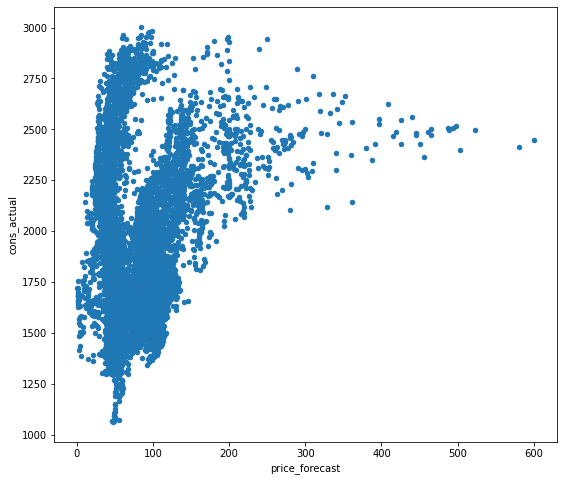

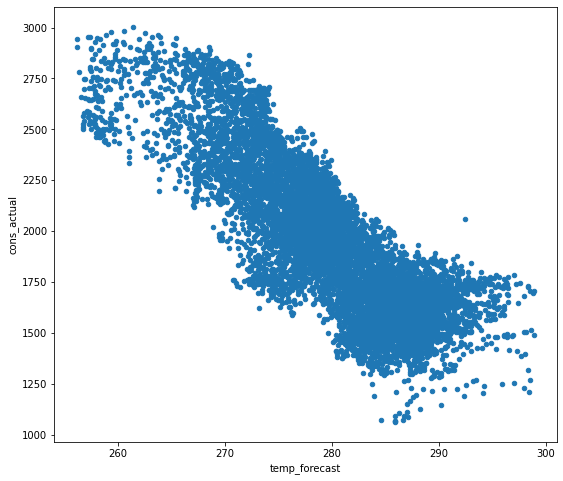

In [819]:
x_price = "price_forecast"
x_temp = "temp_forecast"
y = "cons_actual"
df_watt.plot(x=x_price,y=y,kind="scatter",figsize=(9,8))
df_watt.plot(x=x_temp,y=y,kind="scatter",figsize=(9,8))

### Rounding price to nearest 10 EUR and temperature to nearest °C

In [820]:
df_watt["price_forecast"] = df_watt.price_forecast.round(decimals=-1)
df_watt["temp_forecast"] = df_watt.temp_forecast.round(decimals=0)
df_watt

,cons_actual,price_forecast,temp_forecast
2021-01-01 00:00:00,2202.625,20.0,271.0
2021-01-01 01:00:00,2154.500,20.0,272.0
2021-01-01 02:00:00,2135.625,20.0,271.0
2021-01-01 03:00:00,2176.500,20.0,271.0
2021-01-01 04:00:00,2196.500,20.0,271.0
...,...,...,...
2021-12-30 19:00:00,2109.250,150.0,280.0
2021-12-30 20:00:00,2043.625,140.0,279.0
2021-12-30 21:00:00,2001.250,140.0,279.0
2021-12-30 22:00:00,1919.000,140.0,279.0


### Finding an average consumption by price and temperature

In [821]:
price = df_watt.price_forecast.unique()
temp = df_watt.temp_forecast.unique()

df_watt_price = df_watt[["cons_actual","price_forecast"]]
df_watt_temp = df_watt[["cons_actual","temp_forecast"]]

df_pricesize = pd.DataFrame(df_watt_price.groupby("price_forecast").size())
df_tempsize = pd.DataFrame(df_watt_temp.groupby("temp_forecast").size())

df_pricesize.columns = ["size"]
df_tempsize.columns = ["size"]

df_priceavg = pd.DataFrame(df_watt_price.groupby("price_forecast").mean())
df_tempavg = pd.DataFrame(df_watt_temp.groupby("temp_forecast").mean())

df_priceavg.columns = ["cons_avg"]
df_tempavg.columns = ["cons_avg"]

df_watt_price2 = df_priceavg.join(df_pricesize)
df_watt_temp2 = df_tempavg.join(df_tempsize)

price_size_avg = np.average(df_watt_price2["size"])
temp_size_avg = np.average(df_watt_temp2["size"])

df_watt_price2.drop(df_watt_price2.index[df_watt_price2["size"] < int(0.05*float(price_size_avg))], inplace=True)
df_watt_temp2.drop(df_watt_temp2.index[df_watt_temp2["size"] < int(0.05*float(temp_size_avg))], inplace=True)

df_watt_price2 = df_watt_price2.drop(["size"],axis=1)
df_watt_temp2 = df_watt_temp2.drop(["size"],axis=1)

df_watt_price2

,cons_avg
price_forecast,
0.0,1612.000000
10.0,1754.680556
20.0,1951.341304
30.0,2134.943310
40.0,2055.337086
50.0,1842.143718
60.0,1833.447016
70.0,1908.622328
80.0,1883.698485


### Plotting consumption by price and temperature

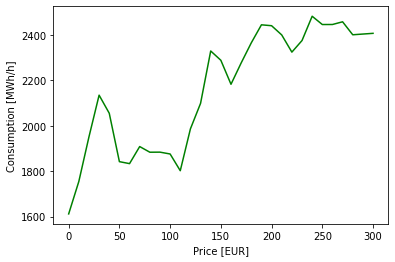

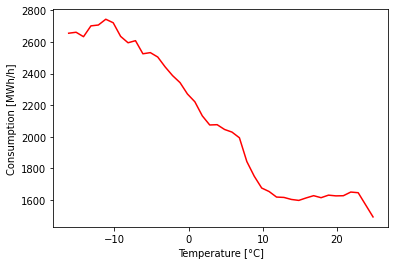

In [822]:
# xs_price = [x for x, y in avg_cons_by_price]
# ys_price = [y for x, y in avg_cons_by_price]
# xs_temp = [x for x, y in avg_cons_by_temp]
# ys_temp = [y for x, y in avg_cons_by_temp]

xs_price = df_watt_price2.index.to_numpy()
ys_price = df_watt_price2[["cons_avg"]].to_numpy()
xs_temp = df_watt_temp2.index.to_numpy()
ys_temp = df_watt_temp2[["cons_avg"]].to_numpy()

plt.plot(xs_price,ys_price,color="g")
plt.xlabel("Price [EUR]")
plt.ylabel("Consumption [MWh/h]")
plt.show()
plt.plot(xs_temp-273.15,ys_temp,color="r")
plt.xlabel("Temperature [°C]")
plt.ylabel("Consumption [MWh/h]")
plt.show()

### Interpolating missing values

In [823]:
# We need to add 10 to max price and 1 to max temp to get the full range of prices and temperatures
all_prices = np.arange(min(xs_price),max(xs_price)+10,10.0)
all_temps = np.arange(min(xs_temp),max(xs_temp)+1,1.0)
all_cons_by_price = np.zeros(len(all_prices))
all_cons_by_temp = np.zeros(len(all_temps))

# This loop sets the consumption by price values to the already known value if it exists, otherwise NaN
for i in range(len(all_prices)):
    if all_prices[i] in xs_price:
        all_cons_by_price[i] = ys_price[np.where(xs_price == all_prices[i])[0][0]]
    else:
        all_cons_by_price[i] = np.nan

# The same for temperature
for i in range(len(all_temps)):
    if all_temps[i] in xs_temp:
        all_cons_by_temp[i] = ys_temp[np.where(xs_temp == all_temps[i])[0][0]]
    else:
        all_cons_by_temp[i] = np.nan

# Interpolating the missing values
all_cons_by_price = np.array(pd.Series(all_cons_by_price).interpolate())
all_cons_by_temp = np.array(pd.Series(all_cons_by_temp).interpolate())

### Calculating price and temperature sensitivity

In [824]:
# We can't find the derivative of the last value
mod_ders_price = np.zeros(len(xs_price)-1)
mod_ders_temp = np.zeros(len(xs_temp)-1)
all_prices = all_prices.tolist()
all_temps = all_temps.tolist()

# Using some crude numerical derivation
for i in range(len(mod_ders_price)):
    index = all_prices.index(xs_price[i])
    mod_ders_price[i] = np.sqrt(xs_price[i])*((all_cons_by_price[index+1]-all_cons_by_price[index])/(all_prices[index+1]-all_prices[index]))

# The same but for temperature
for i in range(len(mod_ders_temp)):
    index = all_temps.index(xs_temp[i])
    mod_ders_temp[i] = -(1/np.sqrt(xs_temp[i]))*((all_cons_by_temp[index+1]-all_cons_by_temp[index])/(all_temps[index+1]-all_temps[index]))

# Finding the sensitivity
sens_by_price = np.average(mod_ders_price)  
sens_by_temp = np.average(mod_ders_temp)

print("NB: Note that these numbers are not in the same metric and cannot be compared!")
print("Price sensitivity:", sens_by_price)
print("Temperature sensitivity:", sens_by_temp)

NB: Note that these numbers are not in the same metric and cannot be compared!
Price sensitivity: 20.615777369878177
Temperature sensitivity: 1.632593084841858
